# Importance sampling in Gen

Adapted from the curve-fitting example in https://www.gen.dev/tutorials/intro-to-modeling/tutorial

In [1]:
using Gen
using Plots

ArgumentError: ArgumentError: Package Plots not found in current path.
- Run `import Pkg; Pkg.add("Plots")` to install the Plots package.

## 1. Writing a probabilistic model as a generative function  <a name="writing-model"></a>

### Example: Bayesian linear regression

Suppose we have a dataset of points $(x, y)$ in the plane, and we'd like 
to infer a likely slope and intercept that explains their (linear) relationship.
To approach this problem from a probabilistic perspective, we first need to
develop a model. The model answers the question: how might this dataset have
come to be? It also encodes our assumptions, e.g., our assumption that our
data is explained by a linear relationship between $x$ and $y$.

The generative function below represents a probabilistic model of a linear
relationship in the x-y plane. Given a set of $x$ coordinates, it randomly
chooses a line in the plane and generates corresponding $y$ coordinates so
that each $(x, y)$ is near the line. We might think of this function as
modeling house prices as a function of square footage, or the measured volume
of a gas as a function of its measured temperature.

In [2]:
@gen function line_model(xs::Vector{Float64})
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope = ({:slope} ~ normal(0, 1))
    intercept = ({:intercept} ~ normal(0, 2))
    
    # We define a function to compute y for a given x
    function y(x)
        return slope * x + intercept
    end

    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        # Note that we name each random choice in this loop
        # slightly differently: the first time through,
        # the name (:y, 1) will be used, then (:y, 2) for
        # the second point, and so on.
        ({(:y, i)} ~ normal(y(x), 0.1))
    end

    # Most of the time, we don't care about the return
    # value of a model, only the random choices it makes.
    # It can sometimems be useful to return something
    # meaningful, however; here, we return the function `y`.
    return y
end;

The generative function takes as an argument a vector of x-coordinates. We create one below:

In [3]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

Given this vector, the generative function samples a random choice
representing the slope of a line from a normal distribution with mean 0 and
standard deviation 1, and a random choice representing the intercept of a
line from a normal distribution with mean 0 and standard deviation 2. In
Bayesian statistics terms, these distributions are the *prior distributions*
of the slope and intercept respectively. Then, the function samples values
for the y-coordinates corresponding to each of the provided x-coordinates.

This generative function returns a function `y` encoding the slope
and intercept. 
We can run the model like we run a regular Julia function:

In [6]:
y = line_model(xs)
println(y)

y


This gives us the return value of the model, but we
may be more interested in _the values of the random choices_ that
`line_model` makes. **Crucially, each random choice is annotated with a
unique *address*.** A random choice is assigned an address using the `{addr} ~ ...`
keyword. Addresses can be any Julia value. In this program, there are two
types of addresses used -- Julia symbols and tuples of symbols and integers.
Note that within the `for` loop, the same line of code is executed multiple
times, but each time, the random choice it makes is given a distinct address.

Although the random choices are not included in the return value, they *are*
included in the *execution trace* of the generative function. We can run the
generative function and obtain its trace using the [`
simulate`](https://www.gen.dev/docs/stable/ref/gfi/#Gen.simulate) method
from the Gen API:

In [7]:
trace = Gen.simulate(line_model, (xs,));

This method takes the function to be executed, and a tuple of arguments to the function, and returns a trace and a second value that we will not be using in this tutorial. When we print the trace, we see that it is a complex data structure.

In [8]:
println(trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Vector{Float64}], false, Union{Nothing, Some{Any}}[nothing], var"##line_model#225", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:y, 11) => Gen.ChoiceOrCallRecord{Float64}(11.649742977037011, 1.2182365335356058, NaN, true), (:y, 3) => Gen.ChoiceOrCallRecord{Float64}(-1.6153213665496038, 1.1250094501011134, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(3.425597733202625, -3.0789256924799884, NaN, true), (:y, 1) => Gen.ChoiceOrCallRecord{Float64}(-4.951067317171623, 0.9323695038297037, NaN, true), (:y, 8) => Gen.ChoiceOrCallRecord{Float64}(6.610687360122069, 0.5698742875056451, NaN, true), (:y, 7) => Gen.ChoiceOrCallRecord{Float64}(4.844648492599167, -1.4314832492007565, NaN, true), (:y, 5) => Gen.ChoiceOrCallRecord{Float64}(1.818103193738446, 1.2643895309871263, NaN, true), (:y, 6) => Gen.ChoiceOrCallRecord{Float64}(3.47

A trace of a generative function contains various information about an execution of the function. For example, it contains the arguments on which the function was run, which are available with the API method `get_args`:

In [9]:
Gen.get_args(trace)

([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)

The trace also contains the value of the random choices, stored in a map from address to value called a *choice map*. This map is available through the API method [`get_choices`]():

In [10]:
Gen.get_choices(trace)

│
├── (:y, 11) : 11.649742977037011
│
├── (:y, 3) : -1.6153213665496038
│
├── :intercept : 3.425597733202625
│
├── (:y, 1) : -4.951067317171623
│
├── (:y, 8) : 6.610687360122069
│
├── (:y, 7) : 4.844648492599167
│
├── (:y, 5) : 1.818103193738446
│
├── (:y, 6) : 3.4736186221684395
│
├── (:y, 10) : 10.039576169978574
│
├── :slope : 1.6563324404842366
│
├── (:y, 4) : 0.16131282196979624
│
├── (:y, 2) : -3.195698787520593
│
└── (:y, 9) : 8.459617614598553


We can pull out individual values from this map using Julia's subscripting syntax `[...]`:

In [11]:
choices = Gen.get_choices(trace)
choices[:slope]

1.6563324404842366

We can also read the value of a random choice directly from the trace, without having to use `get_choices` first:

In [12]:
trace[:slope]

1.6563324404842366

The return value is also recorded in the trace, and is accessible with the `get_retval` API method:

In [13]:
Gen.get_retval(trace)

y (generic function with 1 method)

Or we can access the return value directly from the trace via the syntactic sugar `trace[]`:

In [14]:
trace[]

y (generic function with 1 method)

In order to understand the probabilistic behavior of a generative function, it is helpful to be able to visualize its traces. Below, we define a function that uses PyPlot to render a trace of the generative function above. The rendering shows the x-y data points and the line that is represented by the slope and intercept choices.

In [15]:
function render_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs, = get_args(trace)
    
    xmin = minimum(xs)
    xmax = maximum(xs)

    # Pull out the return value, useful for plotting
    y = get_retval(trace)
    
    # Draw the line
    test_xs = collect(range(-5, stop=5, length=1000))
    fig = plot(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                xlim=(xmin, xmax), ylim=(xmin, xmax))

    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # Plot the data set
        scatter!(xs, ys, c="black", label=nothing)
    end
    
    return fig
end;

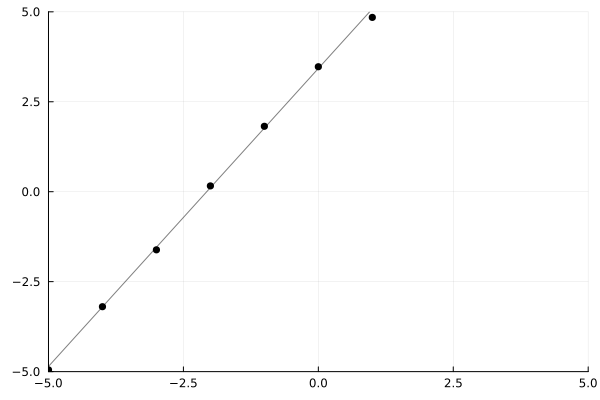

In [16]:
render_trace(trace)

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavior. The cell below renders a grid of traces.

In [17]:
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;

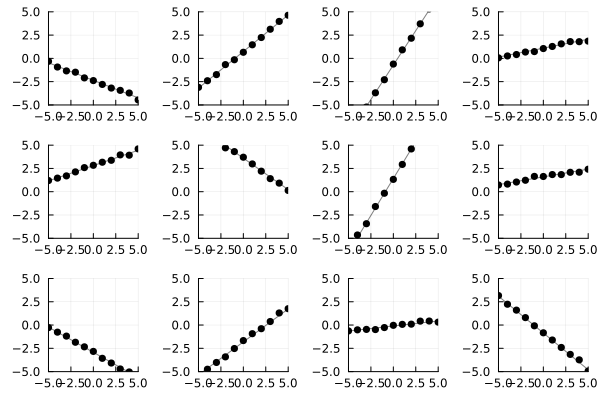

In [18]:
traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

<hr>
<!-- # Solution:
@gen function sine_model(xs)
    period = {:period} ~ gamma(1, 1)
    amplitude = {:amplitude} ~ gamma(1, 1)
    phase = {:phase} ~ uniform(0, 2*pi)

    # Define a deterministic sine wave with the values above
    function y(x)
        return amplitude * sin(x * (2 * pi / period) + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), 0.1)
    end

    return y
end; -->

## 2. Doing Posterior inference  <a name="doing-inference"></a>

Of course, we don't really care about generating lots of pictures of lines
(or sine waves). We'd really like to begin with an actual dataset of observed
$(x, y)$ points, and infer the corresponding slope and intercept (or phase,
period, and amplitude). This task is called _posterior inference_.

We now will provide a data set of y-coordinates and try to draw inferences
about the process that generated the data. We begin with the following data
set:

In [19]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

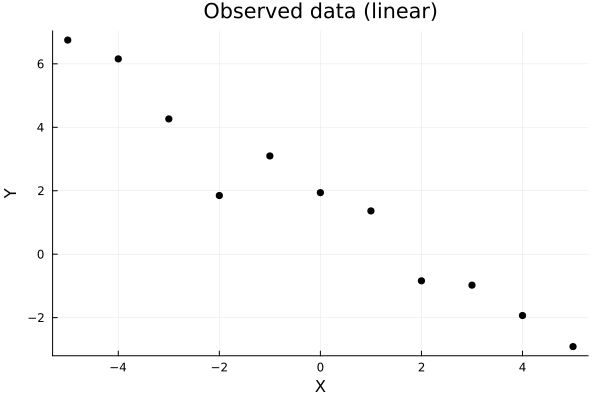

In [20]:
scatter(xs, ys, color="black", label=nothing, title="Observed data (linear)", xlabel="X", ylabel="Y")

We will assume that the line model was responsible for generating the data,
and infer values of the slope and intercept that explain the data.

To do this, we write a simple *inference program* that takes the model we are
assuming generated our data, the data set, and the amount of computation to
perform, and returns a trace of the function that is approximately sampled
from the _posterior distribution_ on traces of the function, given the
observed data. That is, the inference program will try to find a trace that
well explains the dataset we created above. We can inspect that trace to find
estimates of the slope and intercept of a line that fits the data.

Functions like `importance_resampling` expect us to provide a _model_ and
also an _choice map_ representing our data set and relating it to the model.
A choice map maps random choice addresses from the model to values from our
data set. Here, we want to tie model addresses like `(:y, 4)` to data set
values like `ys[4]`:

In [21]:
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

We can run the inference program to obtain a trace, and then visualize the result:

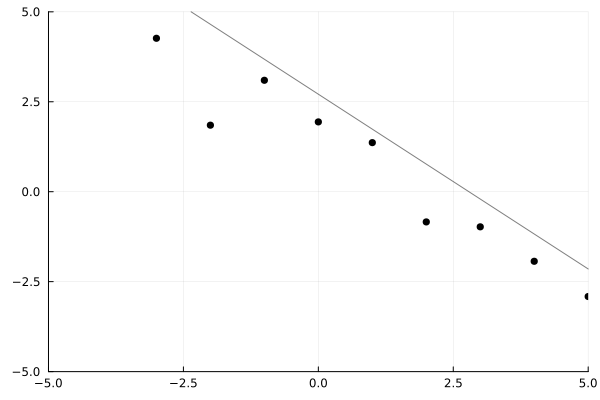

In [22]:
trace = do_inference(line_model, xs, ys, 100)
render_trace(trace)

We see that `importance_resampling` found a reasonable slope and intercept to explain the data. We can also visualize many samples in a grid:

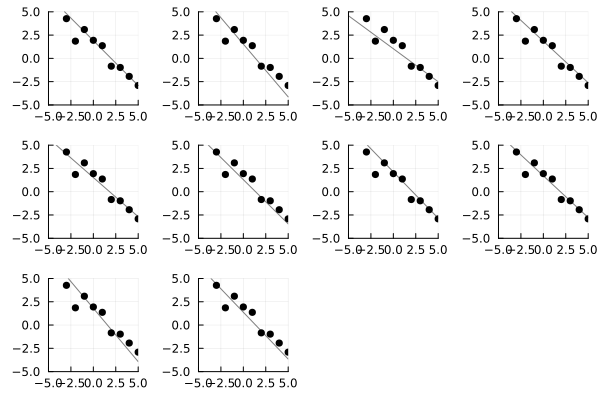

In [23]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

We can see here that there is some uncertainty: with our limited data, we can't be 100% sure exactly where the line is. We can get a better sense for the variability in the posterior distribution by visualizing all the traces in one plot, rather than in a grid. Each trace is going to have the same observed data points, so we only plot those once, based on the values in the first trace:

In [24]:
function overlay(renderer, traces; same_data=true, args...)
    fig = renderer(traces[1], show_data=true, args...)
    
    xs, = get_args(traces[1])
    xmin = minimum(xs)
    xmax = maximum(xs)

    for i=2:length(traces)
        y = get_retval(traces[i])
        test_xs = collect(range(-5, stop=5, length=1000))
        fig = plot!(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                    xlim=(xmin, xmax), ylim=(xmin, xmax))
    end
    return fig
end;

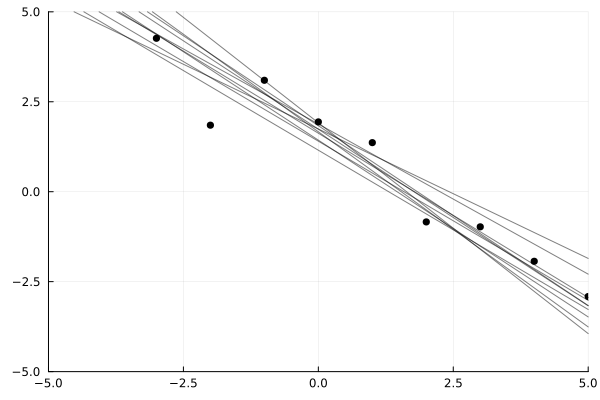

In [25]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
overlay(render_trace, traces)

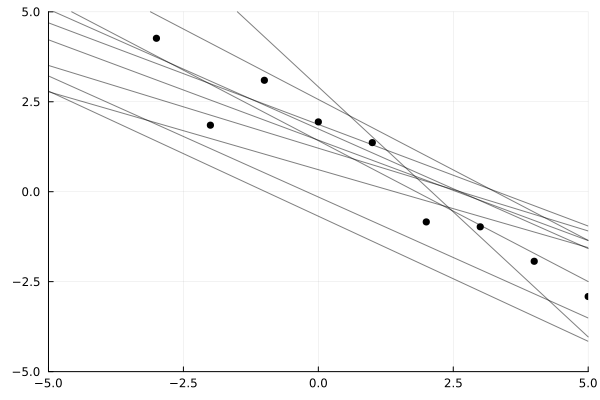

In [26]:
traces = [do_inference(line_model, xs, ys, 10) for _=1:10];
overlay(render_trace, traces)

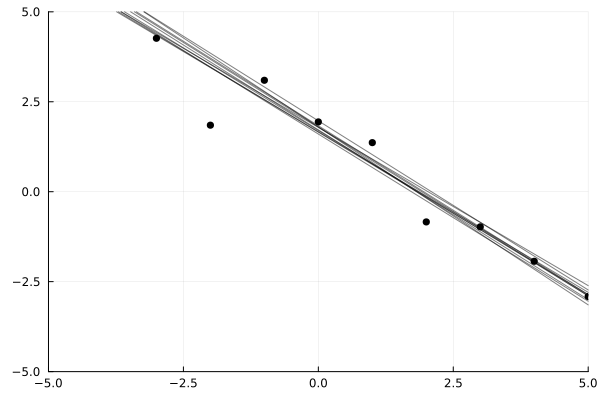

In [27]:
traces = [do_inference(line_model, xs, ys, 1000) for _=1:10];
overlay(render_trace, traces)

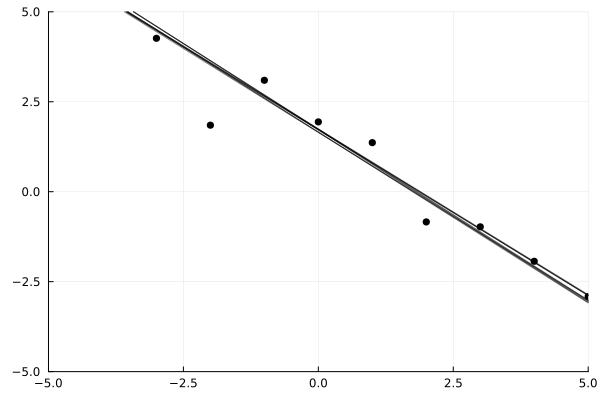

In [28]:
traces = [do_inference(line_model, xs, ys, 10000) for _=1:10];
overlay(render_trace, traces)

## 3. Predicting new data  <a name="predicting-data"></a>

What if we'd want to predict `ys` given `xs`?

Using the API method
[`generate`](https://www.gen.dev/docs/dev/ref/gfi/#Gen.generate), we
can generate a trace of a generative function in which the values of certain
random choices are constrained to given values. The constraints are a choice
map that maps the addresses of the constrained random choices to their
desired values.

For example:


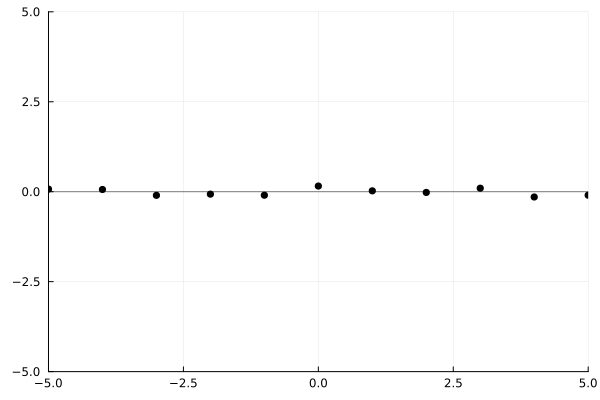

In [29]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.generate(line_model, (xs,), constraints)
render_trace(trace)

Note that the random choices corresponding to the y-coordinates are still made randomly. Run the cell above a few times to verify this.


We will use the ability to run constrained executions of a generative
function to predict the value of the y-coordinates at new x-coordinates by
running new executions of the model generative function in which the random
choices corresponding to the parameters have been constrained to their
inferred values.  We have provided a function below (`predict_new_data`) that
takes a trace, and a vector of new x-coordinates, and returns a vector of
predicted y-coordinates corresponding to the x-coordinates in `new_xs`. We
have designed this function to work with multiple models, so the set of
parameter addresses is an argument (`param_addrs`):


In [30]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    
    # Copy parameter values from the inferred trace (`trace`)
    # into a fresh set of constraints.
    constraints = Gen.choicemap()
    for addr in param_addrs
        constraints[addr] = trace[addr]
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values.
    (new_trace, _) = Gen.generate(model, (new_xs,), constraints)
    
    # Pull out the y-values and return them.
    ys = [new_trace[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

To illustrate, we call the function above given the previous trace (which
constrained slope and intercept to be zero).

In [31]:
predict_new_data(line_model, trace, [1., 2., 3.], [:slope, :intercept])

3-element Vector{Float64}:
 -0.06626894138839429
  0.003367231142516046
  0.03914151700255135

The cell below defines a function that first performs inference on an
observed data set `(xs, ys)`, and then runs `predict_new_data` to generate
predicted y-coordinates. It repeats this process `num_traces` times, and
returns a vector of the resulting y-coordinate vectors.

In [32]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

To illustrate, we generate predictions at `[1., 2., 3.]` given one (approximate) posterior
trace.

In [33]:
pred_ys = infer_and_predict(line_model, xs, ys, [1., 2., 3.], [:slope, :intercept], 1, 1000)

1-element Vector{Any}:
 [0.7756885627423269, -0.1645978413948822, -1.051918118879255]

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [34]:
function plot_predictions(xs, ys, new_xs, pred_ys; title="predictions")
    fig = scatter(xs, ys, color="red", label="observed data", title=title)
    for (i, pred_ys_single) in enumerate(pred_ys)
        scatter!(new_xs, pred_ys_single, color="black", alpha=0.1, label=i == 1 ? "predictions" : nothing)
    end
    return fig
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

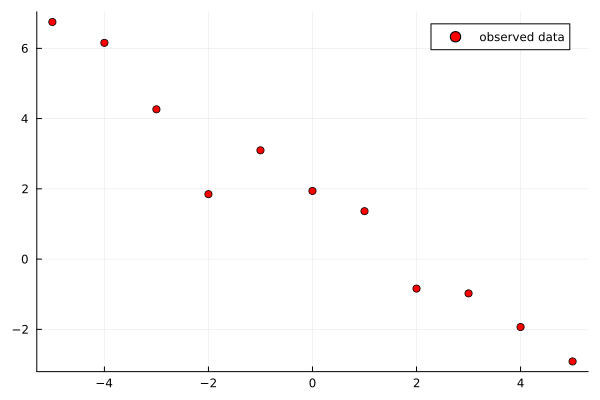

In [35]:
scatter(xs, ys, color="red", label="observed data")

We will use the inferred values of the parameters to predict y-coordinates for x-coordinates in the interval 5 to 10 from which data was not observed. We will also predict new data within the interval -5 to 5, and we will compare this data to the original observed data. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*. This tutorial does not intend to give a rigorous overview behind techniques for checking the quality of a model, but intends to give high-level intuition.

In [36]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data (20 runs of inference and prediction):

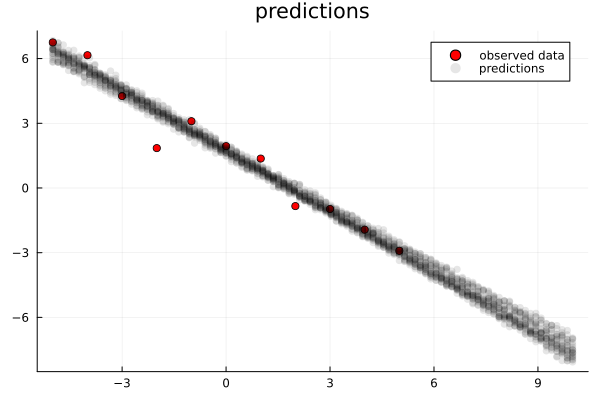

In [37]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with the following data set, which has significantly more noise.

In [38]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

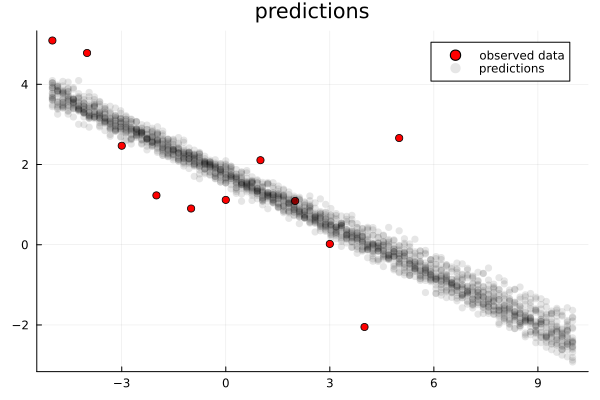

In [39]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

We first write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [40]:
@gen function line_model_fancy(xs::Vector{Float64})
    slope = ({:slope} ~ normal(0, 1))
    intercept = ({:intercept} ~ normal(0, 2))
    
    function y(x)
        return slope * x + intercept
    end
    
    noise = ({:noise} ~ gamma(1, 1))
    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(slope * x + intercept, noise)
    end
    return y
end;

Then, we compare the predictions using inference of the unmodified and modified models on the `ys` data set:

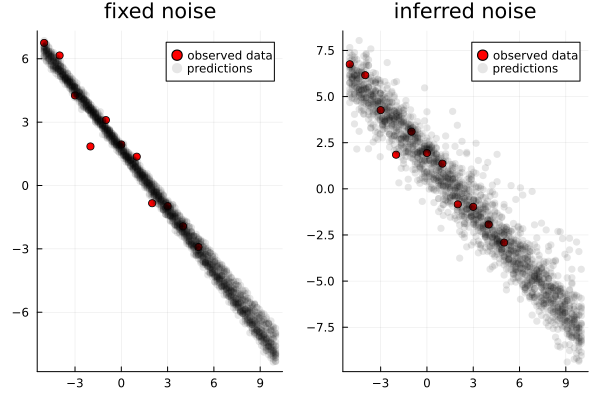

In [41]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
fixed_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="fixed noise")

pred_ys = infer_and_predict(line_model_fancy, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
inferred_noise_plot = plot_predictions(xs, ys, new_xs, pred_ys; title="inferred noise")

plot(fixed_noise_plot, inferred_noise_plot)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference of the unmodified and modified models on the `ys_noisy` data set:

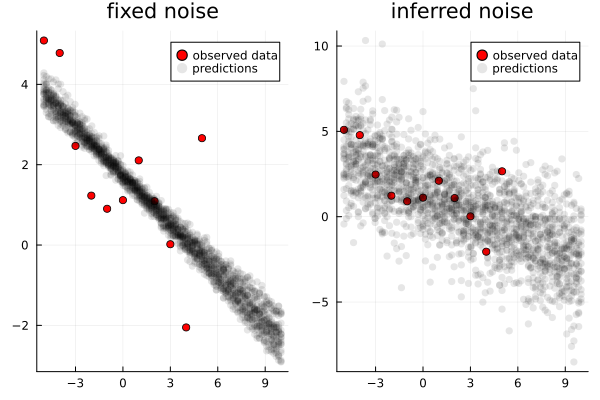

In [42]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
fixed_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="fixed noise")


pred_ys = infer_and_predict(line_model_fancy, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
inferred_noise_plot = plot_predictions(xs, ys_noisy, new_xs, pred_ys; title="inferred noise")

plot(fixed_noise_plot, inferred_noise_plot)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend.

----
<!-- # Solution
@gen function sine_model_fancy(xs::Vector{Float64})
    period = ({:period} ~ gamma(5, 1))
    amplitude = ({:amplitude} ~ gamma(1, 1))
    phase = ({:phase} ~ uniform(0, 2*pi))
    noise = ({:noise} ~ gamma(1, 1))

    function y(x)
        return amplitude * sin(x * (2 * pi / period) + phase)
    end

    for (i, x) in enumerate(xs)
        {(:y, i)} ~ normal(y(x), noise)
    end

    return y
end; -->

## 4. Calling other generative functions  <a name="calling-functions"></a>

In addition to making random choices, generative functions can invoke other
generative functions. To illustrate this, we will write a probabilistic model
that combines the line model and the sine model. This model is able to
explain data using either model, and which model is chosen will depend on the
data. This is called *model selection*.

A generative function can invoke another generative function in three ways:

- **(NOT RECOMMENDED)** using regular Julia function call syntax: `f(x)`

- using the `~` snytax with an address for the call: `{addr} ~ f(x)`

- using the `~` syntax with a wildcard address: `{*} ~ f(x)`

When invoking using regular function call syntax, the random choices made by
the callee function are not traced at all, and Gen cannot reason about them during inference. 
When invoking using `~` with a _wildcard_ address (`{*} ~ f(x)`), the random choices of the 
callee function are imported directly into the caller's trace. So, for example, if `f` makes a choice
called `:f_choice`, then the caller's trace will have a choice called `:f_choice` too. 
Note that a downside of this is that if `f` is called _twice_ by the same caller, then the two 
choices called `:f_choice` will clash, leading to an error.
In this case, it is best to provide an address (`{addr} ~ f(x)`): `f`'s random choices will
be placed under the _namespace_ `addr`. 

In [ ]:
@gen function foo()
    {:y} ~ normal(0, 1)
end

@gen function bar()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with a wildcard address.
    # Its choices (:y) will appear directly
    # within the trace of `bar`.
    {*} ~ foo()
end

@gen function bar_using_namespace()
    {:x} ~ bernoulli(0.5)
    # Call `foo` with the address `:z`.
    # The internal choice `:y` of `foo`
    # will appear in our trace at the
    # hierarchical address `:z => :y`.
    {:z} ~ foo()
end;

We first show the addresses sampled by `bar`:

In [ ]:
trace = Gen.simulate(bar, ())
Gen.get_choices(trace)

And the addresses sampled by `bar_using_namespace`:

In [ ]:
trace = Gen.simulate(bar_using_namespace, ())
Gen.get_choices(trace)

Using `{addr} ~ f()`, with a namespace, can help avoid address collisions for complex models.

A hierarchical address is represented as a Julia `Pair`, where the first element of the pair is the first element of the address and the second element of the pair is the rest of the address:

In [ ]:
trace[Pair(:z, :y)]

Julia uses the `=>` operator as a shorthand for the `Pair` constructor, so we can access choices at hierarchical addresses like:

In [ ]:
trace[:z => :y]

If we have a hierarchical address with more than two elements, we can construct the address by chaining the `=>` operator:

In [ ]:
@gen function baz()
    {:a} ~ bar_using_namespace()
end

trace = simulate(baz, ())

get_choices(trace)

In [ ]:
trace[:a => :z => :y]

Note that the `=>` operator associated right, so this is equivalent to:

In [ ]:
trace[Pair(:a, Pair(:z, :y))]